In [1]:
import sys
sys.path.append('..')
from pathlib import Path
import gzip
import urllib
import tempfile
from datetime import datetime
from dateutil import tz

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import cartopy.feature as cfeature
from cartopy import crs as ccrs
from metpy.plots import USCOUNTIES, ctables
import metpy.calc as mpcalc

from Map import Map
from spc.reports import plot_spc_reports

In [2]:
LOCATION = 'texas'

In [3]:
def xr_read_compressed_dataset(URL):
    response = urllib.request.urlopen(URL)
    compressed_file = response.read()

    with tempfile.NamedTemporaryFile(suffix='.grib2') as f:
        f.write(gzip.decompress(compressed_file))
        return xr.load_dataset(f.name)

In [4]:
ds = xr_read_compressed_dataset('https://mrms.ncep.noaa.gov/data/2D/MultiSensor_QPE_72H_Pass2/'
                                'MRMS_MultiSensor_QPE_72H_Pass2.latest.grib2.gz')
ds

<xarray.Dataset>
Dimensions:         (latitude: 3500, longitude: 7000)
Coordinates:
    time            datetime64[ns] 2023-04-29T03:00:00
    step            timedelta64[ns] 00:00:00
    heightAboveSea  float64 0.0
  * latitude        (latitude) float64 54.99 54.98 54.98 ... 20.03 20.02 20.01
  * longitude       (longitude) float64 230.0 230.0 230.0 ... 300.0 300.0 300.0
    valid_time      datetime64[ns] 2023-04-29T03:00:00
Data variables:
    unknown         (latitude, longitude) float32 13.4 13.4 13.2 ... 0.0 0.0 0.0
Attributes:
    GRIB_edition:            2
    GRIB_centre:             161
    GRIB_centreDescription:  161
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             161
    history:                 2023-04-28T23:55 GRIB to CDM+CF via cfgrib-0.9.1...

In [5]:
BOTTOM_LAT = 24
TOP_LAT = 38
LEFT_LON = -110
RIGHT_LON = -80

LAT_SLICE = slice(TOP_LAT, BOTTOM_LAT)
LON_SLICE = slice(360 + LEFT_LON, 360 + RIGHT_LON)

In [6]:
d = ds.sel(latitude=LAT_SLICE, longitude=LON_SLICE)
mrms_values = d.unknown

def convert_datetime(mrms_time):
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz('America/Chicago')
    utc_time = datetime.strptime(mrms_time, '%Y-%m-%dT%H:%M:%S').replace(tzinfo=from_zone)
    eastern = utc_time.astimezone(to_zone)
    date_time = datetime.strftime(eastern, '%a, %b %d, %Y %I:%M %p').lstrip('0').replace(' 0', ' ')
    return date_time

VALID_TIME = convert_datetime(str(d.time.values).split('.')[0])

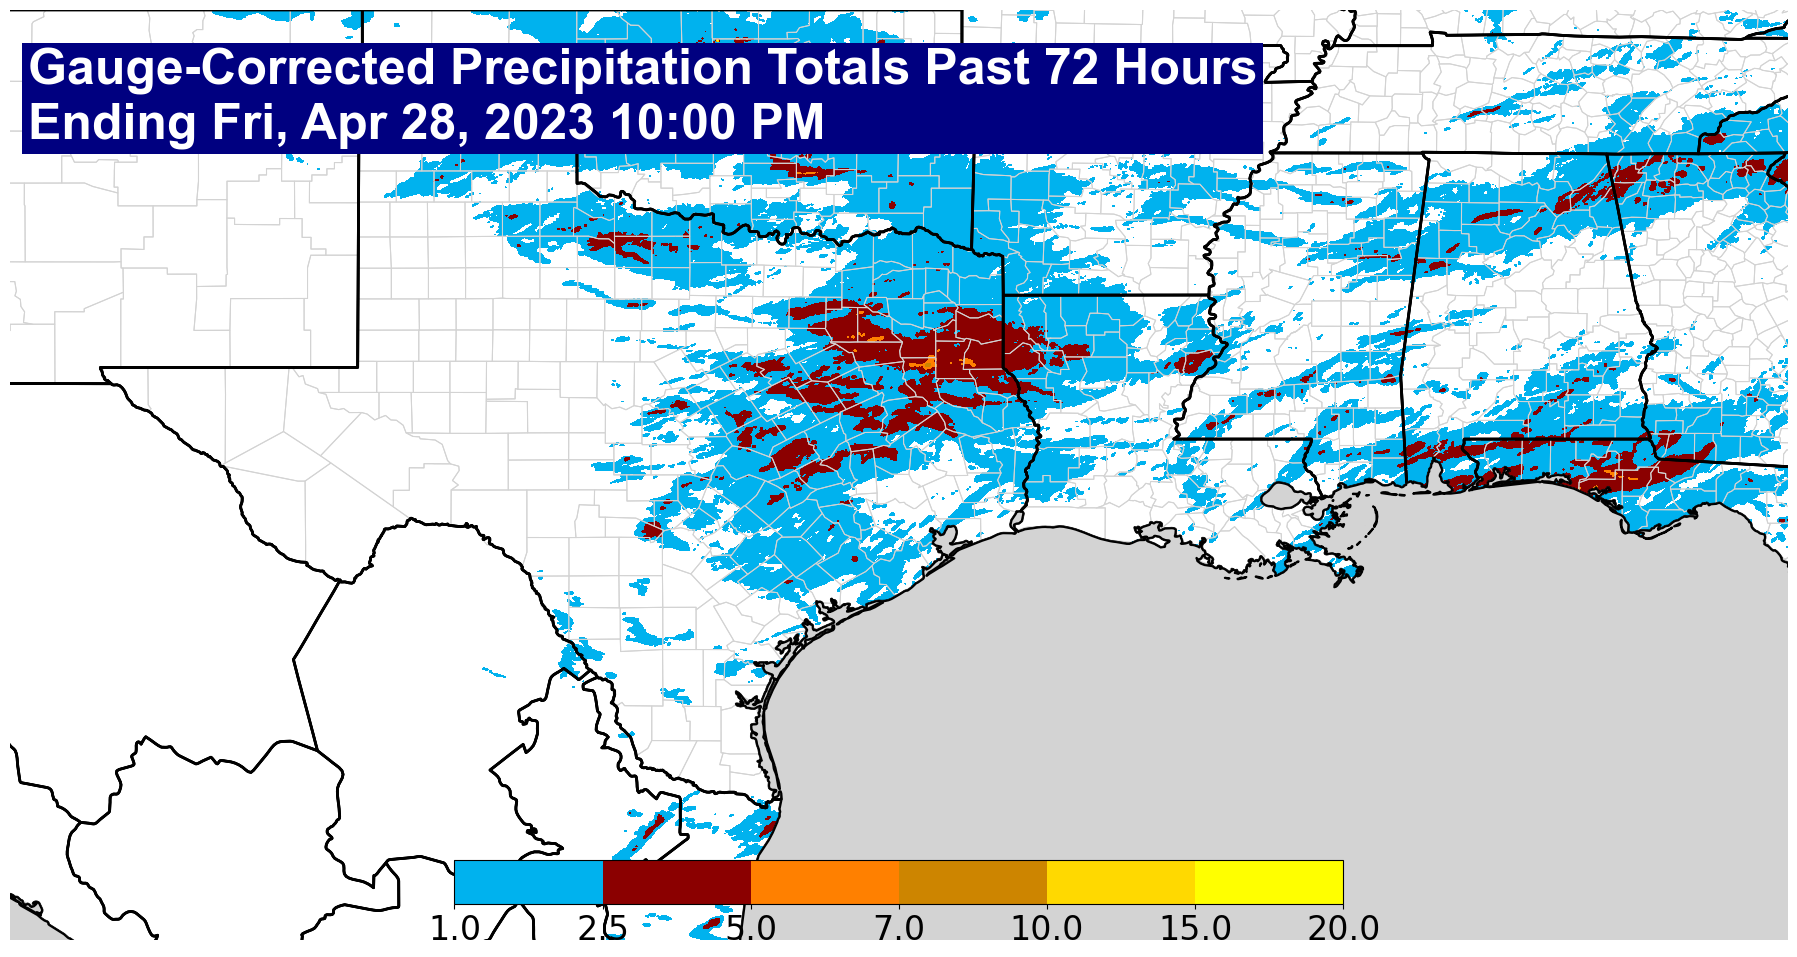

In [7]:
new_map = Map(LOCATION)
new_map.add_counties()
new_map.add_title(f'Gauge-Corrected Precipitation Totals Past 72 Hours\nEnding {VALID_TIME}')

def conceal_outlook_over_ocean(ax):
    ax.add_feature(cfeature.OCEAN.with_scale('10m'), color='lightgray', zorder=9)
    ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=1.5, zorder=10)

fig, ax = new_map.make_map()
conceal_outlook_over_ocean(ax)

colors = ['#00b2ee', '#8b0000', '#ff8000', '#cd8500', '#ffd900', '#ffff00', '#ffaeb9']
contour = ax.contourf(d.longitude, d.latitude, mrms_values/25.4, 
                     [1.00, 2.50, 5.00, 7.00, 10.00, 15.00, 20.00], 
                     colors=colors, transform=ccrs.PlateCarree())


cbar = plt.colorbar(contour, orientation='horizontal', pad=-0.08, shrink=0.5,)
cbar.ax.tick_params(labelsize='24')

# Save and show figure
graphics_dir = Path('.') / '..' / '..' / 'graphics' / 'mrms'
fig.savefig(f'{graphics_dir}/rain_gauge_corr_{LOCATION}.png', dpi=72)